In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("raw_tables_2023_03_05/raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)
    # tweet_df.to_csv('raw_tweets_out.csv')
    print(tweet_df["content"].head(5))

0    I applaud North Carolina’s announcement to exp...
1    I’m so proud to have the Young Men’s Leadershi...
2    Happy Women’s History Month! When women succee...
3                    Stay safe out there, North Texas!
4    Wishing my fellow Texans everywhere a happy Te...
Name: content, dtype: object


In [32]:
from nltk.stem import PorterStemmer
import emoji

ps = PorterStemmer()

tweet_df_sample = tweet_df.sample(n = 10000)

tweet_df_sample["content_words"] = tweet_df_sample["content"].apply(word_tokenize)
tweet_df_sample["content_words"] = tweet_df_sample["content_words"].apply(lambda words: [emoji.replace_emoji(ps.stem(word.lower())) for word in words])
tweet_df_sample["content_words_length"] = tweet_df_sample["content_words"].apply(len)

print(tweet_df_sample["content_words"].head(5))

4056266    [la, solicitud, para, el, alivio, de, la, deud...
4284626    [as, we, prepar, to, celebr, texa, independ, d...
2234887    [two, of, these, (, the, furthest, east, of, ~...
4052410    [thank, for, all, your, question, !, thi, wa, ...
4210122    [as, a, former, school, teacher, ,, i, want, t...
Name: content_words, dtype: object


                  word  count      idf
25449                ✓      1  9.21044
12111      hillary2016      1  9.21044
12113      hillaryland      1  9.21044
12114         hillgrov      1  9.21044
21151             soft      1  9.21044
12116  hillsboroughsch      1  9.21044
12117             hilo      1  9.21044
12118           hilton      1  9.21044
25347      zelenskyyua      1  9.21044
12120             hime      1  9.21044


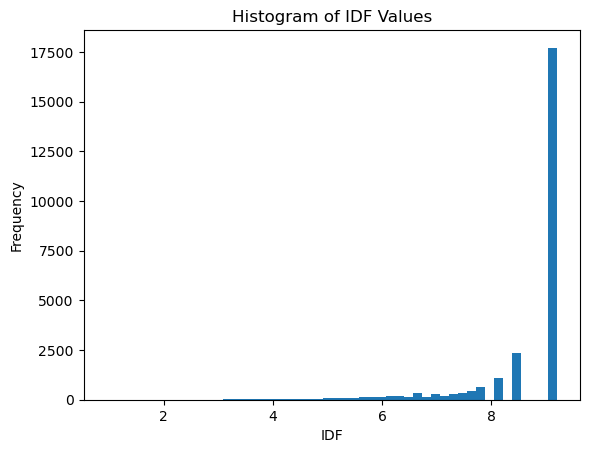

In [36]:
import numpy as np

id_list = []
word_list = []

for index, row in tweet_df_sample.iterrows():
    for word in set(row["content_words"]): 
        id_list.append(row["id"])
        word_list.append(word)


words_df = pd.DataFrame({"id": id_list, "word": word_list})
num_docs = tweet_df_sample.shape[0]

word_counts_df = words_df.groupby("word").count()
word_counts_df = word_counts_df.rename(columns={"id": "count"}).reset_index()
word_counts_df = word_counts_df.sort_values(by="count", ascending=True)

word_counts_df["idf"] = np.log(num_docs / word_counts_df["count"] + 1)

print(word_counts_df.head(10))

# Create a histogram of the IDF values
plt.hist(word_counts_df["idf"], bins=50)

# Set the plot title and axis labels
plt.title("Histogram of IDF Values")
plt.xlabel("IDF")
plt.ylabel("Frequency")

# Show the plot
plt.show()


In [37]:
word_counts_df.to_csv('word_counts_df.csv')
print(word_counts_df.shape)
print(num_docs)

(25450, 3)
10000


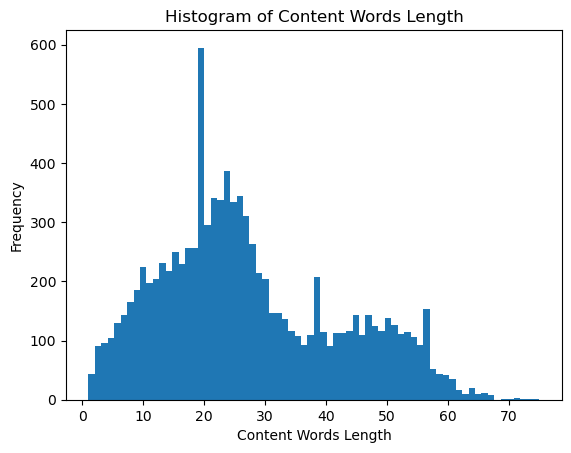

In [39]:
# Create a histogram of content_words_length
plt.hist(tweet_df_sample["content_words_length"], bins=70)

# Set the plot title and axis labels
plt.title("Histogram of Content Words Length")
plt.xlabel("Content Words Length")
plt.ylabel("Frequency")

# Show the plot
plt.show()